In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

#import warnings
#warnings.filterwarnings('ignore') # Suppress skl k-NN param warnings 

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

#import graphviz

# This is a Markdown cell
Here we can write stuff, including LaTeX commands. To create one, go to the menu call at the top, then Cell $\rightarrow$ Cell Type $\rightarrow$ Markdown.

Here is a matrix
$$
\textbf{X} =  \begin{bmatrix}
    1 & 2 \\
    1 & 3 \\ 
\end{bmatrix}
$$

In [68]:
# Read the data
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
train

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


# 3 Data analysis task

The first step – before we start to build a model – is always to take a closer look at the data by
analyzing some statistics of the data set. In this step you can already gain some insights into the data
which helps you interpret the results of your methods later in the project.
Look into the provided data set by e.g. plotting the individual features. Based on your analysis,
answer the following questions:

- Do men or women dominate speaking roles in Hollywood movies?
- Has gender balance in speaking roles changed over time (i.e. years)?
- Do films in which men do more speaking make a lot more money than films in which women speak more?

Write 1-2 sentences for each question and support your findings with evidence (statistics, plots, ...).

In [20]:
femaleAct = train['Number of female actors']
maleAct = train['Number of male actors']
sumMale = np.sum(maleAct)
sumFemale = np.sum(femaleAct)
sumTot = sumMale + sumFemale
print((int)(100*sumMale/sumTot))
print((int)(100*sumFemale/sumTot))

68
31


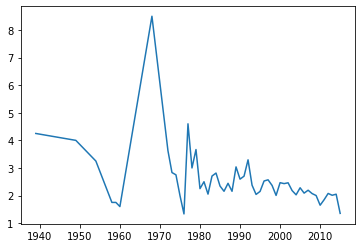

In [59]:
test = train.groupby('Year') 
g1 = test.get_group(1939)
df=train.groupby('Year').sum()
femaleAct = df['Number of female actors']
maleAct = df['Number of male actors']
totAct = femaleAct+maleAct
percMale = maleAct / totAct
percFemale = femaleAct / totAct

ratio = maleAct / femaleAct

plt.plot(df.index,ratio)
#plt.plot(df.index,percFemale)

In [95]:
train['wordsFemale'] = train['Number words female'] + (train['Lead'] == 'Female')*train['Number of words lead']
train['wordsMale'] = train['Number words male'] + (train['Lead'] == 'Male')*train['Number of words lead']
train['wordsRatio'] = train['wordsFemale'] / train['wordsMale']
train['mostlyMale'] = train['wordsRatio'] < 1
train['mostlyFemale'] = train['wordsRatio'] > 1
avgFemaleMajority =  (int)(np.mean(train['Gross'][train['mostlyFemale']== True]))
avgMaleMajority =  (int)(np.mean(train['Gross'][train['mostlyMale']== True]))
stdFemaleMajority =  (int)(np.std(train['Gross'][train['mostlyFemale']== True]))
stdMaleMajority =  (int)(np.std(train['Gross'][train['mostlyMale']== True]))
print(avgFemaleMajority, varFemaleMajority, avgMaleMajority, varMaleMajority)

82 106 116 158


# 4 Implementation of Methods
## 4.1 Methods to explore
The course has (so far) covered the five following ‘families’ of classification methods:

- logistic regression
- discriminant analysis: LDA, QDA
- K-nearest neighbor
- Tree-based methods: classification trees, random forests, bagging
- Boosting

In this project, you decide upon at least as many ‘families’ as you are group members, and decide in
each ‘family’ at least one method to explore. To be clear, **each group member should independently
implement and write about one method.** Who implemented which method should later be clearly
written in the contribution statement. All group members should be able to stand for all sections of
the report.

**Additionally**, you should include a naive classifier that always predicts male as the lead actor in your
analysis and compare its performance with your methods.

*Deep learning, which will be covered later, is also possible to use for classification. You are of course
welcome to explore this as well, in addition to the minimum requirements.*

## 4.2 What to do with each method
For *each* method you decide to explore, you should do the following:

1. Implement the method. We suggest that you use Python, and you may write your own code or use packages (the material from the problem solving sessions can be useful).
2. Tune the method to perform well.
3. Evaluate its performance using, e.g., cross validation. Exactly how to carry this out is up for you to decide.

Once you have completed the aforementioned tasks, you should with a good motivation (hint: cross
validation) select which method you decide to use ‘in production’ on a test set that will be made
available later. **Work on this part of the project together and write the results together.**